In [94]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op ='', label=''):
        self.data = data
        self.grad = 0.0         # Initialize the gradient for backprop
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __radd__(self, other):
        return self+other
    
    def __truediv__(self, other):
        return self*other**-1
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other -1) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x= self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        
        for nodes in reversed(topo):
            nodes._backward()
    

In [96]:
#pip install graphviz

from graphviz import Digraph

def trace(root):
    #builds nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={"rankdir": 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value, create a rectangular ('record') node for it
        # node_label = n.label if n.label else 'W/B' if not n._op and not n._prev else n._op
        
        dot.node(name = uid, 
                 label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ),
                 shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
       # connect n1 to op node n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot    

In [97]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813, label='b')
# x1w1 + x2w2 + b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n = x1w1x2w2 + b; n. label = '"n'
o = n.tanh(); o.label="o"
o.backward()

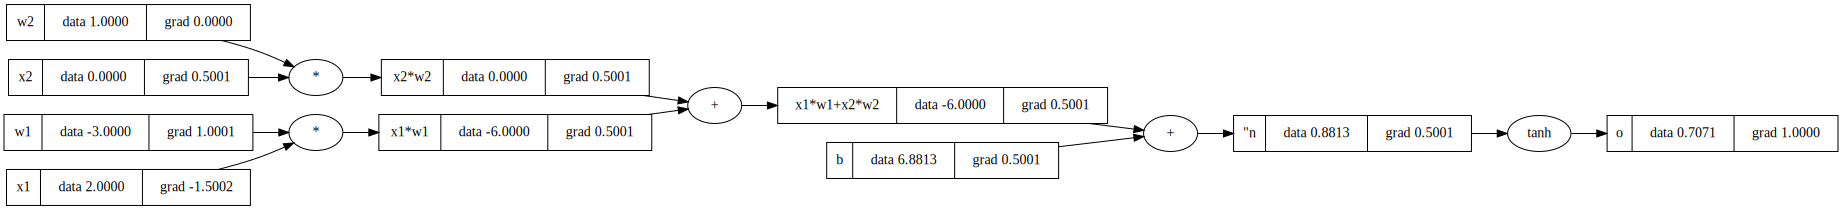

In [98]:
draw_dot(o)

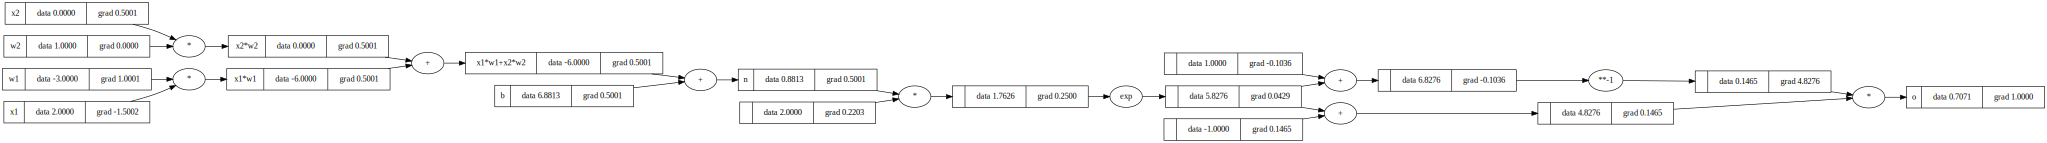

In [99]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813, label='b')
# x1w1 + x2w2 + b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n = x1w1x2w2 + b; n. label = 'n'

e = (2*n).exp()
o = (e-1) / (e+1)

o.label="o"
o.backward()

draw_dot(o)

In [100]:
#For Multi-Layer Perceptrons

class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1,1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for  _ in range(n_out)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
            

class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [107]:
x = [2.0, 2.0, -1.0]
n = MLP(3,[4,4,1])

n(x)

Value(data=0.09567810653537413)

In [109]:
len(n.parameters())

41

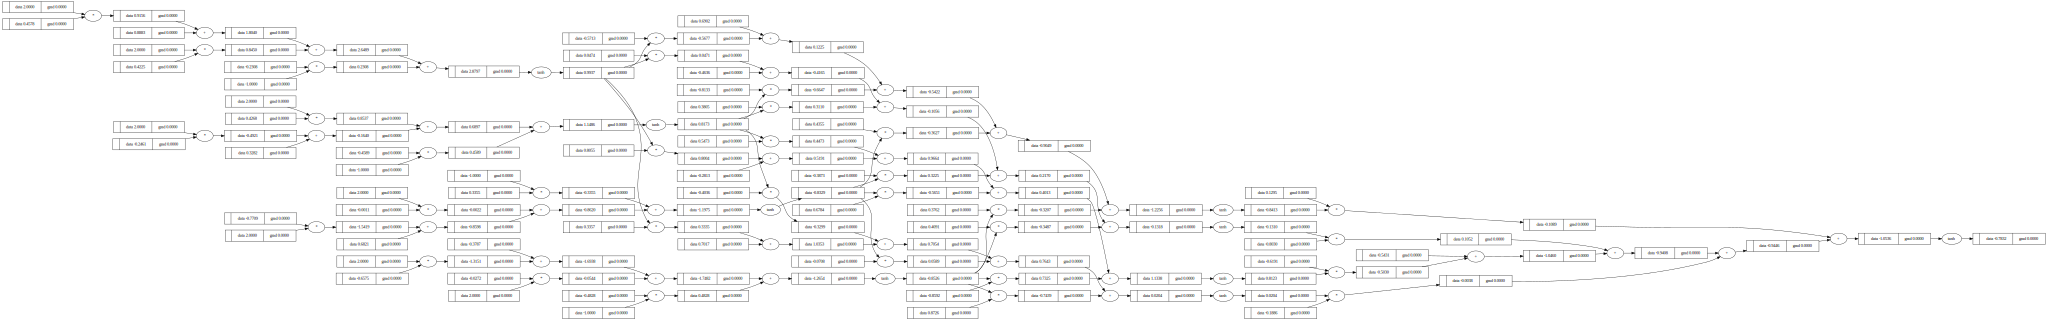

In [103]:
draw_dot(n(x))

In [104]:
# sample dataset

xs = [
    [3.0, 2,0, -1.0],
    [2.0, -1.0, 0.5],
    [-1.0, 1.0, 0.5],
    [1.0, 2.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [105]:
for i in range(20):
        
    ypred = [n(x) for x in xs]
    loss = sum([(yout -yt)**2 for yt, yout in zip(ys, ypred)])

    for p in n.parameters():
        p.grad = 0.0
        
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(i, loss.data)
    
    
    

0 6.747592547298445
1 6.440832237588516
2 6.069192712219314
3 5.641388522189841
4 5.184697701112492
5 4.738680798247216
6 4.338141484307053
7 3.999386618267631
8 3.7201828715039937
9 3.488371720868861
10 3.2899441507399922
11 3.113133070615252
12 2.9494452918281606
13 2.793304236429746
14 2.641339004142019
15 2.4917397979323175
16 2.3437797245909078
17 2.1974829976709285
18 2.0533909724758477
19 1.912382585445909


In [106]:
loss

Value(data=1.912382585445909)

In [69]:
ypred

[Value(data=-0.9999999999008904),
 Value(data=-0.9999999996754984),
 Value(data=0.9999999999998321),
 Value(data=-0.9999999979884869)]

In [65]:
n.parameters()

[Value(data=0.3650547262010007),
 Value(data=-0.46474241094966867),
 Value(data=0.5679604519619262),
 Value(data=0.4997548956171205),
 Value(data=-0.9418708921117593),
 Value(data=-0.20502405365616008),
 Value(data=0.6936704560396373),
 Value(data=0.4431534067171771),
 Value(data=-0.20200481353717223),
 Value(data=-0.8982622718168858),
 Value(data=2.379853167371393),
 Value(data=-0.3614294726770196),
 Value(data=0.3504435500656713),
 Value(data=-2.1004710124743187),
 Value(data=-1.0816441807580797),
 Value(data=-1.6517751492163562),
 Value(data=1.3613597954246532),
 Value(data=-0.6254079167053566),
 Value(data=0.29535719546080724),
 Value(data=-0.15647967550519118),
 Value(data=-0.7462107604946748),
 Value(data=-3.086202315713996),
 Value(data=-2.20739616612998),
 Value(data=-2.4788014948427906),
 Value(data=-2.645771502487506),
 Value(data=0.6788007949230384),
 Value(data=0.9541978963228198),
 Value(data=-0.309058762221128),
 Value(data=1.0633267812067277),
 Value(data=0.9875437788813